<a href="https://colab.research.google.com/github/Thibooooo/Optimisation-Course/blob/main/E7_Thibault_Germain_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Northwest Corner Rule:
Solution Matrix:
[[20.  0.  0.]
 [ 5. 25.  0.]
 [ 0.  0. 25.]]
Total Cost: 905.0

Minimum Cost Method:
Solution Matrix:
[[ 0. 20.  0.]
 [ 5.  0. 25.]
 [20.  5.  0.]]
Total Cost: 665.0

Minimum Row Cost Method:
Solution Matrix:
[[ 0. 20.  0.]
 [ 5.  0. 25.]
 [20.  5.  0.]]
Total Cost: 665.0

Vogel's Approximation Method:
Solution Matrix:
[[20.  0.  0.]
 [ 5.  0. 25.]
 [ 0. 25.  0.]]
Total Cost: 605.0

Transportation Simplex Algorithm:
Solution Matrix:
[[20.  0.  0.]
 [ 5. 25.  0.]
 [ 0.  0. 25.]]
Total Cost: 905.0


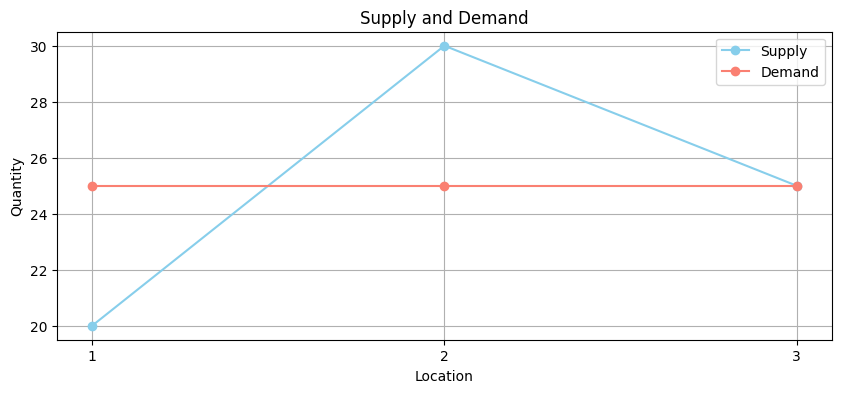

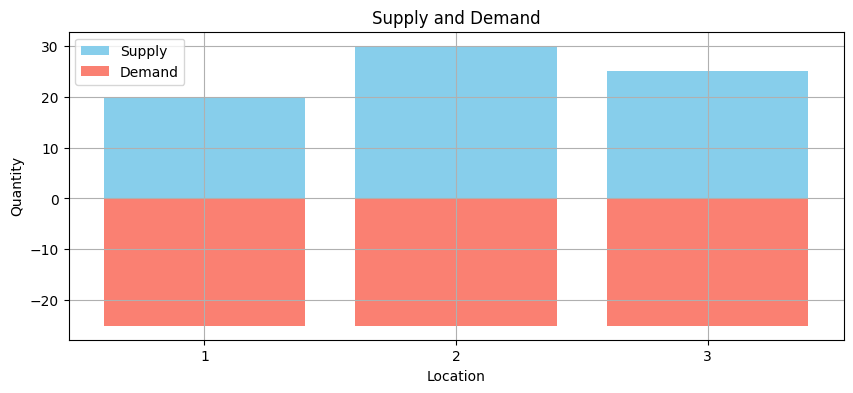

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_transportation_params(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    supply_line = next(line for line in lines if 'Supply' in line)
    demand_line = next(line for line in lines if 'Demand' in line)
    cost_start_index = lines.index("Cost\n")
    cost_lines = lines[cost_start_index + 1:]
    supply = np.array([int(val.strip()) for val in supply_line.split(",")[1:]])
    demand = np.array([int(val.strip()) for val in demand_line.split(",")[1:]])

    cost_matrix = []
    for cost_line in cost_lines:
        if cost_line.strip():
            cost_values = [float(val.strip()) for val in cost_line.split(",")]
            cost_matrix.append(cost_values)
    cost = np.array(cost_matrix)
    return supply, demand, cost

def northwest_corner_rule(supply, demand, cost):
    n = len(supply)
    m = len(demand)
    if n > m:
        demand = np.append(demand, [0] * (n - m))
        m = n
    elif m > n:
        supply = np.append(supply, [0] * (m - n))
        n = m

    x = np.zeros((n, m))
    i, j = 0, 0

    while i < n and j < m:
        allocation = min(supply[i], demand[j])
        x[i, j] = allocation
        supply[i] -= allocation
        demand[j] -= allocation
        if supply[i] == 0:
            i += 1
        elif demand[j] == 0:
            j += 1

    total_cost = np.sum(x * cost)
    return x, total_cost


def minimum_cost_method(supply, demand, cost):
    n = len(supply)
    m = len(demand)
    x = np.zeros((n, m))
    remaining_supply = supply.copy()
    remaining_demand = demand.copy()
    cost_copy = cost.copy()
    while np.sum(remaining_supply) > 0:
        min_cost = np.min(cost_copy)
        indices = np.where(cost_copy == min_cost)
        i, j = indices[0][0], indices[1][0]
        allocation = min(remaining_supply[i], remaining_demand[j])
        x[i, j] = allocation
        remaining_supply[i] -= allocation
        remaining_demand[j] -= allocation
        cost_copy[i, j] = float('inf')

    total_cost = np.sum(x * cost)
    return x, total_cost

def minimum_row_cost_method(supply, demand, cost):
    n = len(supply)
    m = len(demand)
    x = np.zeros((n, m))
    remaining_supply = supply.copy()
    remaining_demand = demand.copy()
    cost_copy = cost.copy()
    for i in range(n):
        while remaining_supply[i] > 0:
            min_cost = np.min(cost_copy[i])
            j = np.where(cost_copy[i] == min_cost)[0][0]
            allocation = min(remaining_supply[i], remaining_demand[j])
            x[i, j] = allocation
            remaining_supply[i] -= allocation
            remaining_demand[j] -= allocation
            cost_copy[i, j] = float('inf')
    total_cost = np.sum(x * cost)
    return x, total_cost

def vogels_approximation_method(supply, demand, cost):
    n = len(supply)
    m = len(demand)
    x = np.zeros((n, m))
    remaining_supply = supply.copy()
    remaining_demand = demand.copy()
    cost_copy = cost.copy()
    while np.sum(remaining_supply) > 0:
        row_penalty = []
        col_penalty = []

        for i in range(n):
            available_costs = cost_copy[i][cost_copy[i] != float('inf')]
            if len(available_costs) > 1:
                row_penalty.append(np.sort(available_costs)[1] - np.sort(available_costs)[0])
            else:
                row_penalty.append(0)

        for j in range(m):
            available_costs = cost_copy[:, j][cost_copy[:, j] != float('inf')]
            if len(available_costs) > 1:
                col_penalty.append(np.sort(available_costs)[1] - np.sort(available_costs)[0])
            else:
                col_penalty.append(0)

        if max(row_penalty) >= max(col_penalty):
            i = np.argmax(row_penalty)
            min_cost = np.min(cost_copy[i])
            j = np.where(cost_copy[i] == min_cost)[0][0]
        else:
            j = np.argmax(col_penalty)
            min_cost = np.min(cost_copy[:, j])
            i = np.where(cost_copy[:, j] == min_cost)[0][0]

        allocation = min(remaining_supply[i], remaining_demand[j])
        x[i, j] = allocation
        remaining_supply[i] -= allocation
        remaining_demand[j] -= allocation
        cost_copy[i, j] = float('inf')
    total_cost = np.sum(x * cost)
    return x, total_cost


def transportation_simplex_algorithm(supply, demand, cost):
    initial_solution, _ = northwest_corner_rule(supply.copy(), demand.copy(), cost.copy())
    basic_variables = np.argwhere(initial_solution > 0)
    while True:

        reduced_costs = np.zeros_like(cost)
        for i in range(len(supply)):
            for j in range(len(demand)):
                if (i, j) not in basic_variables:
                    reduced_costs[i, j] = cost[i, j] - row_potential[i] - column_potential[j]
        if np.all(reduced_costs >= 0):
            break
        i_enter, j_enter = np.unravel_index(np.argmin(reduced_costs), reduced_costs.shape)
        theta = min(supply[i_enter], demand[j_enter])
        for i, j in basic_variables:
            if i == i_enter:
                theta = min(theta, initial_solution[i, j_enter])
            elif j == j_enter:
                theta = min(theta, initial_solution[i_enter, j])
        for i, j in basic_variables:
            if i == i_enter:
                initial_solution[i, j] -= theta
            elif j == j_enter:
                initial_solution[i, j] -= theta
        initial_solution[i_enter, j_enter] += theta
        basic_variables = np.argwhere(initial_solution > 0)
    total_cost = np.sum(initial_solution * cost)
    return initial_solution, total_cost
def plot_supply_demand(supply, demand):
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(len(supply)) + 1, supply, marker='o', linestyle='-', color='skyblue', label='Supply')
    plt.plot(np.arange(len(demand)) + 1, demand, marker='o', linestyle='-', color='salmon', label='Demand')
    plt.xlabel('Location')
    plt.ylabel('Quantity')
    plt.title('Supply and Demand')
    plt.xticks(np.arange(max(len(supply), len(demand))) + 1)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_supply_demand_diag(supply, demand):
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(len(supply)) + 1, supply, color='skyblue', label='Supply')
    plt.bar(np.arange(len(demand)) + 1, -demand, color='salmon', label='Demand')
    plt.xlabel('Location')
    plt.ylabel('Quantity')
    plt.title('Supply and Demand')
    plt.xticks(np.arange(max(len(supply), len(demand))) + 1)
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = 'E7_Opti_Thibault.txt'
supply, demand, cost = read_transportation_params(file_path)
northwest_solution, northwest_cost = northwest_corner_rule(supply.copy(), demand.copy(), cost.copy())
min_cost_solution, min_cost_total = minimum_cost_method(supply.copy(), demand.copy(), cost.copy())
min_row_cost_solution, min_row_cost_total = minimum_row_cost_method(supply.copy(), demand.copy(), cost.copy())
vogels_solution, vogels_cost = vogels_approximation_method(supply.copy(), demand.copy(), cost.copy())
simplex_solution, simplex_cost = transportation_simplex_algorithm(supply.copy(), demand.copy(), cost.copy())
print("Northwest Corner Rule:")
print("Solution Matrix:")
print(northwest_solution)
print("Total Cost:", northwest_cost)
print("\nMinimum Cost Method:")
print("Solution Matrix:")
print(min_cost_solution)
print("Total Cost:", min_cost_total)
print("\nMinimum Row Cost Method:")
print("Solution Matrix:")
print(min_row_cost_solution)
print("Total Cost:", min_row_cost_total)
print("\nVogel's Approximation Method:")
print("Solution Matrix:")
print(vogels_solution)
print("Total Cost:", vogels_cost)
print("\nTransportation Simplex Algorithm:")
print("Solution Matrix:")
print(simplex_solution)
print("Total Cost:", simplex_cost)
plot_supply_demand(supply, demand)
plot_supply_demand_diag(supply, demand)
